# Analysis

In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt

### Settings

In [2]:
# Set core metrics
core_metrics = ['fks', 'vader', 'subj', 'liwc']

### Loading 

In [3]:
# Set path to load files from
res_path = '/Users/tom/Documents/GitCode/Confidence_Scanner/scripts/results/'
#res_path = '/Users/wdfox/Documents/GitCode/Confidence_Scanner/scripts/results/'

In [4]:
# Load files
dfs = []
for dat_type in ['Papers', 'PRs']:
    
    d1 = pd.read_csv(os.path.join(res_path, dat_type + '_readability.csv'))
    d2 = pd.read_csv(os.path.join(res_path, dat_type + '_analysis.csv'))
    d3 = pd.read_csv(os.path.join(res_path, dat_type + '_metadata.csv'))
    
    # Merge dataframes - to get all features for particular document type
    dft = pd.merge(d1, d2, on=['id', 'term'])
    df = pd.merge(dft, d3, on=['id', 'term'])
    df['dat_type'] = dat_type
    
    dfs.append(df)

In [5]:
# Combine into one joint df, with all data (papers and press releases)
df = pd.concat(dfs)

In [6]:
## Cleans ups
df.set_index('id', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop old data columns (remove when analysis re-run)
df = df.drop(['fk', 'consen'], axis=1)

In [7]:
# Drop any documents which have zero words
nb = len(df)
df = df[df['n_words'] > 0]
na = len(df)
print(nb - na)

1


In [8]:
# Test: Drop any documents which have zero scores on subjectivity / sentiment
#df = df[df['liwc'] != 0]
#df = df[df['subj'] != 0]

In [9]:
# Check out a few rows
df.head()

,term,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link,region,journal,dat_type
id,,,,,,,,,,,,,,,,,,
29373119,autism,16.6,18.2,15.2,18.86,7.500000,1.0194,-1.0,3.0,6.0,143,9,NaN,NaN,NaN,NaN,Biological psychiatry,Papers
29369294,autism,18.2,22.2,17.7,12.46,7.916667,-2.5924,-2.0,5.0,6.0,189,11,NaN,NaN,NaN,NaN,Acta neurobiologiae experimentalis,Papers
29367178,autism,15.1,14.8,13.1,35.07,7.000000,0.9111,2.0,-2.0,8.0,125,8,NaN,NaN,NaN,NaN,Epilepsy research,Papers
29361396,autism,21.3,23.7,19.8,12.30,18.000000,-0.9329,-3.0,0.0,0.0,116,6,NaN,NaN,NaN,NaN,Neuromuscular disorders : NMD,Papers
29358944,autism,17.3,18.5,16.5,21.02,13.125000,0.0173,1.0,-1.0,6.0,101,7,NaN,NaN,NaN,NaN,Frontiers in genetics,Papers


### Clean Ups & Control for document length

Optional analysis in which relevant measures are normalized by word length

In [10]:
# Normalize relevant measures
#df['liwc'] = df['liwc'] / df['n_words']
df['subj'] = df['subj'] / df['n_sentences']

In [11]:
# Remove outliers
n_before = len(df)
for metric in core_metrics:
    std3 = 4 * df[metric].std()
    std_max = df[metric].mean() + std3
    std_min = df[metric].mean() - std3

    df = df[df[metric] > std_min]
    df = df[df[metric] < std_max]
n_after = len(df)

print(n_before - n_after, 'data points dropped.')

187 data points dropped.


### Explore

In [12]:
# Check how many there are of each data type
df['dat_type'].value_counts()

Papers    9900
PRs       5484
Name: dat_type, dtype: int64

In [13]:
# Check how many documents there are for each term
df['term'].value_counts()

diabetes         2511
stroke           1953
perception       1657
vaccines         1406
dementia         1304
cognition        1302
autism           1263
hypertension     1231
epilepsy         1073
consciousness    1026
optogenetics      658
Name: term, dtype: int64

In [14]:
# Check how many of each document there are, split up by document type and term
df.groupby(['dat_type', 'term']).size()

dat_type  term         
PRs       autism            309
          cognition         337
          consciousness      76
          dementia          377
          diabetes         1641
          epilepsy          198
          hypertension      325
          optogenetics       53
          perception        679
          stroke           1043
          vaccines          446
Papers    autism            954
          cognition         965
          consciousness     950
          dementia          927
          diabetes          870
          epilepsy          875
          hypertension      906
          optogenetics      605
          perception        978
          stroke            910
          vaccines          960
dtype: int64

In [15]:
# Descriptive statistics
df.describe()

,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link
count,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,15384.000000,5484.000000,5484.000000,5484.000000
mean,15.339749,17.043838,13.943077,33.322161,11.161383,0.627837,-0.452028,-0.158256,3.138131,200.296867,12.372855,0.359774,0.454595,0.034829
std,2.383679,3.198832,2.786461,14.031163,3.821226,2.403060,4.347188,0.427598,5.092216,137.266038,7.930250,0.479978,0.497980,0.183362
min,0.000000,5.000000,3.300000,-23.790000,1.500000,-9.898900,-25.000000,-2.166667,-18.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,14.000000,15.000000,12.200000,24.170000,8.200000,-0.653350,-3.000000,-0.428571,0.000000,115.000000,7.000000,0.000000,0.000000,0.000000
50%,15.300000,17.000000,13.900000,34.260000,10.900000,0.539100,0.000000,-0.142857,3.000000,149.000000,10.000000,0.000000,0.000000,0.000000
75%,16.800000,19.000000,15.700000,43.020000,13.250000,1.800525,2.000000,0.111111,6.000000,261.000000,15.000000,1.000000,1.000000,0.000000
max,26.200000,39.700000,30.900000,85.080000,55.500000,11.193500,22.000000,1.750000,24.000000,2310.000000,102.000000,1.000000,1.000000,1.000000


In [16]:
# Check out the descriptive statistics separated out by dat_type
pd.set_option('display.max_columns', 100)
df.groupby(['dat_type']).describe()

ar                                                       fkg  \
           count       mean       std  min   25%   50%   75%   max   count   
dat_type                                                                     
PRs       5484.0  16.818563  2.386898  8.3  15.2  16.7  18.3  39.7  5484.0   
Papers    9900.0  17.168626  3.563975  5.0  14.8  17.2  19.4  37.6  9900.0   

                                                               fks             \
               mean       std  min   25%   50%   75%   max   count       mean   
dat_type                                                                        
PRs       13.668691  2.008009  5.6  12.3  13.6  14.9  23.4  5484.0  39.742349   
Papers    14.095071  3.125318  3.3  12.0  14.2  16.2  30.9  9900.0  29.765766   

                                                        has_article_link  \
                std    min    25%    50%     75%    max            count   
dat_type                                                                   
PRs        9.659541  -1.55  33.48  40.18  46.910  74.73           5484.0   
Papers    14.791018 -23.79  19.90  29.59  39.385  85.08              0.0   

                                                     has_other_link            \
              mean      std  min  25%  50%  75%  max          count      mean   
dat_type                                                                        
PRs       0.454595  0.49798  0.0  0.0  0.0  1.0  1.0         5484.0  0.034829   
Papers         NaN      NaN  NaN  NaN  NaN  NaN  NaN            0.0       NaN   

                                            has_source_link            \
               std  min  25%  50%  75%  max           count      mean   
dat_type                                                                
PRs       0.183362  0.0  0.0  0.0  0.0  1.0          5484.0  0.359774   
Papers         NaN  NaN  NaN  NaN  NaN  NaN             0.0       NaN   

                                                liu             ...    liwc  \
               std  min  25%  50%  75%  max   count      mean   ...     75%   
dat_type                                                        ...           
PRs       0.479978  0.0  0.0  0.0  1.0  1.0  5484.0 -0.409555   ...     9.0   
Papers         NaN  NaN  NaN  NaN  NaN  NaN  9900.0 -0.475556   ...     5.0   

                   lwf                                                    \
           max   count       mean       std  min    25%   50%        75%   
dat_type                                                                   
PRs       24.0  5484.0  12.624788  4.049417  1.5  10.20  12.5  14.666667   
Papers    23.0  9900.0  10.350745  3.429991  1.5   7.75  10.4  12.500000   

                n_sentences                                              \
            max       count       mean       std  min   25%   50%   75%   
dat_type                                                                  
PRs       30.25      5484.0  19.126368  9.291453  1.0  13.0  18.0  24.0   
Papers    55.50      9900.0   8.631818  3.262855  1.0   6.0   8.0  10.0   

                n_words                                                    \
            max   count        mean         std  min    25%    50%    75%   
dat_type                                                                    
PRs       102.0  5484.0  331.874544  148.344075  2.0  240.0  311.0  399.0   
Papers     43.0  9900.0  127.410808   46.768428  3.0   99.0  126.0  149.0   

                    smog                                                    \
             max   count       mean       std  min   25%   50%   75%   max   
dat_type                                                                     
PRs       2310.0  5484.0  15.016922  1.620417  0.0  14.0  14.9  16.0  23.0   
Papers    1095.0  9900.0  15.518576  2.699181  0.0  13.9  15.7  17.3  26.2   

            subj                                                              \
           count      mean       std       min       2

## PR specific Stuff

In [17]:
# Check documents by region (PR only)
df['region'].value_counts()

namerica     4130
europe       1083
asia          164
australia      42
africa         35
samerica       15
Name: region, dtype: int64

In [18]:
# Check how many have links
print('Article Link: ', '\t', df['has_article_link'].mean())
print('Source Link: ', '\t', df['has_source_link'].mean())
print('Other Link: ', '\t', df['has_other_link'].mean())

Article Link:  	 0.45459518599562365
Source Link:  	 0.3597738876732312
Other Link:  	 0.03482859226841721


## Analyses

In [19]:
# Check correlation between metrics
corrs = df[core_metrics].corr()
corrs

,fks,vader,subj,liwc
fks,1.000000,0.021874,-0.063477,0.092309
vader,0.021874,1.000000,0.032823,0.109342
subj,-0.063477,0.032823,1.000000,-0.109454
liwc,0.092309,0.109342,-0.109454,1.000000


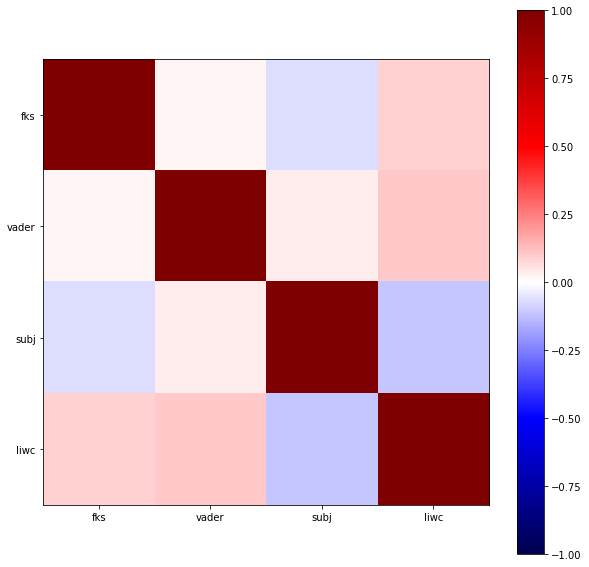

In [20]:
# Plot the correlation matrix
plt.figure(figsize=[10, 10])
plt.imshow(corrs.values, cmap='seismic', vmin=-1, vmax=1);
plt.xticks(range(len(corrs)), list(corrs.columns));
plt.yticks(range(len(corrs)), list(corrs.columns));
plt.colorbar()

In [21]:
from scipy.stats import pearsonr

In [22]:
for m1 in core_metrics:
    for m2 in core_metrics:
        print(m1, m2, '\t', pearsonr(df[m1], df[m2]))

fks fks 	 (1.0, 0.0)
fks vader 	 (0.021873727430179627, 0.0066646560226648896)
fks subj 	 (-0.063477232639422509, 3.2598946647414814e-15)
fks liwc 	 (0.092308871488286162, 1.806152883917297e-30)
vader fks 	 (0.021873727430179627, 0.0066646560226648896)
vader vader 	 (1.0, 0.0)
vader subj 	 (0.032822907554893047, 4.6638118538830793e-05)
vader liwc 	 (0.10934200472580384, 3.9160540961605672e-42)
subj fks 	 (-0.063477232639422509, 3.2598946647414814e-15)
subj vader 	 (0.032822907554893047, 4.6638118538830793e-05)
subj subj 	 (1.0, 0.0)
subj liwc 	 (-0.10945360912114356, 3.2348975202484131e-42)
liwc fks 	 (0.092308871488286162, 1.806152883917297e-30)
liwc vader 	 (0.10934200472580384, 3.9160540961605672e-42)
liwc subj 	 (-0.10945360912114356, 3.2348975202484131e-42)
liwc liwc 	 (1.0, 0.0)


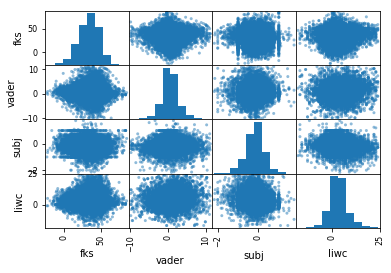

In [23]:
# Plot relations between metrics
pd.plotting.scatter_matrix(df[core_metrics]);

In [24]:
# Check the average scores for each measure across different terms
avgs = df.groupby(['term', 'dat_type'])[core_metrics].mean()
avgs

fks     vader      subj      liwc
term          dat_type                                         
autism        PRs       38.787670  1.598084 -0.211667  5.378641
              Papers    26.790189  0.227726 -0.076816  2.538784
cognition     PRs       39.455193  2.258407 -0.143614  4.465875
              Papers    26.134881  0.509349 -0.049563  2.519171
consciousness PRs       38.876447  0.100830 -0.176762  3.960526
              Papers    29.822600 -0.075455 -0.105812  2.101053
dementia      PRs       38.926048  1.320386 -0.228502  4.432361
              Papers    29.156861  0.436985 -0.105298  2.406688
diabetes      PRs       39.383918  1.134928 -0.266318  4.793419
              Papers    33.662092  0.344294 -0.175189  2.851724
epilepsy      PRs       42.019495  1.201752 -0.161874  4.696970
              Papers    31.787600  0.270679 -0.122106  2.267429
hypertension  PRs       38.229877  0.162498 -0.262349  4.741538
              Papers    33.916115  0.042915 -0.185483  2.747241
optogenetics  PRs       39.246038  2.492258 -0.194150  5.584906
              Papers    17.674777  0.625200 -0.037255  1.897521
perception    PRs       40.111414  1.781499 -0.135167  2.321060
              Papers    29.829468  0.587061 -0.094460  2.483640
stroke        PRs       40.582483  0.493217 -0.234870  4.383509
              Papers    35.919044  0.049812 -0.189776  2.874725
vaccines      PRs       40.400717  1.343768 -0.301260  4.791480
              Papers    29.335667  0.702610 -0.157629  2.076042

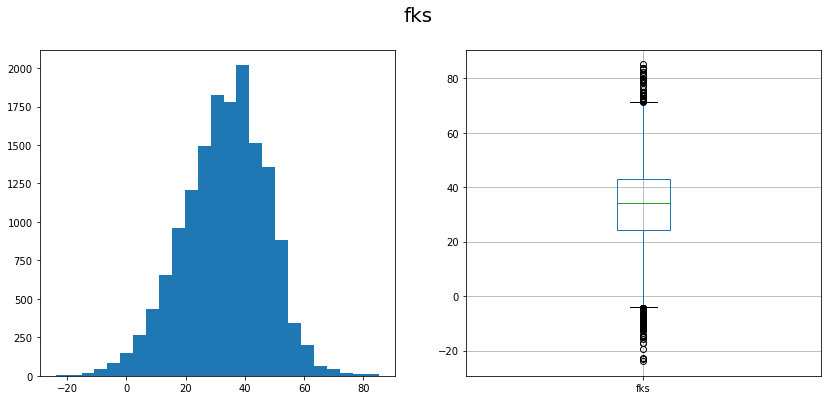

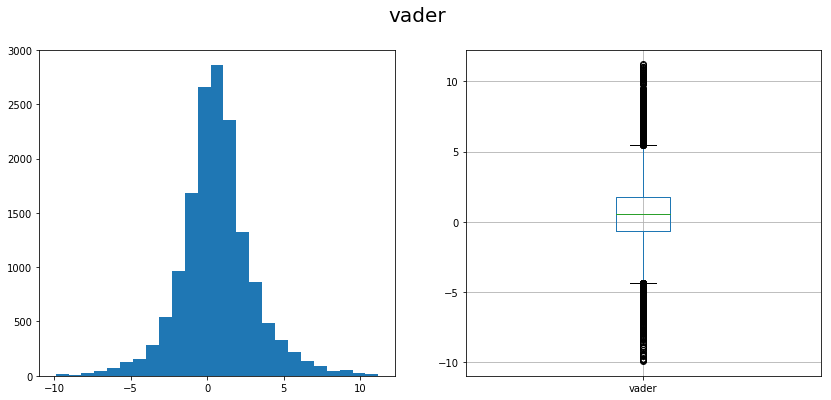

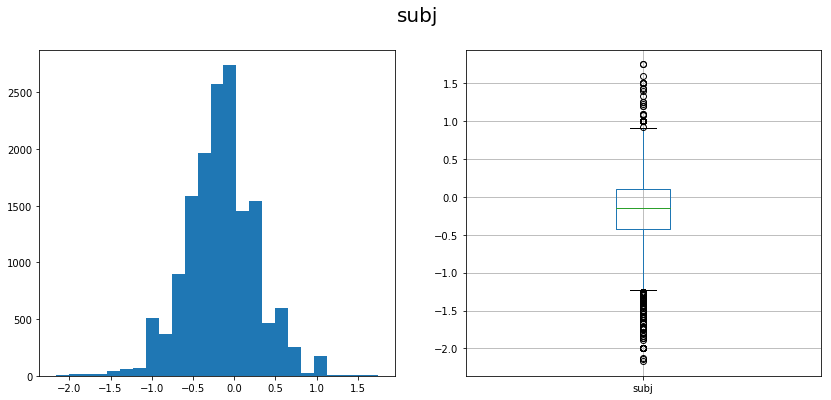

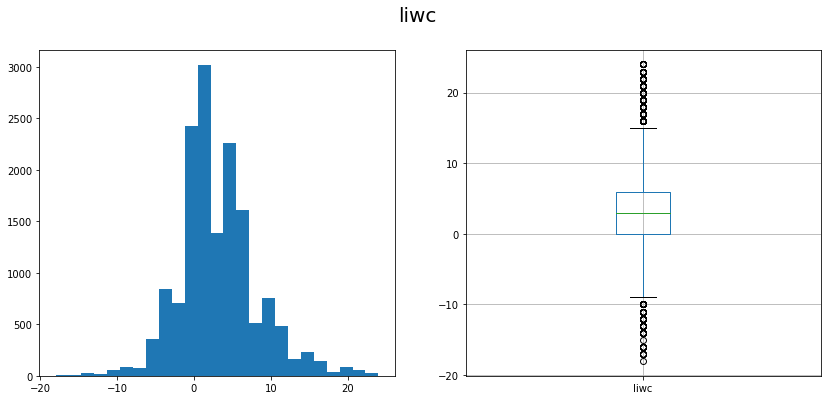

In [25]:
# Plot measures, collapsed across data type
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    ax[0].hist(df[metric], bins=25);
    pd.plotting.boxplot(df, metric, ax=ax[1]);
    plt.suptitle(metric, fontsize=20)

In [26]:
# Check the average differences between data types
df.groupby('dat_type')[core_metrics].mean()

,fks,vader,subj,liwc
dat_type,,,,
PRs,39.742349,1.161377,-0.227776,4.386761
Papers,29.765766,0.332289,-0.119746,2.446465


In [27]:
core_metrics

['fks', 'vader', 'subj', 'liwc']

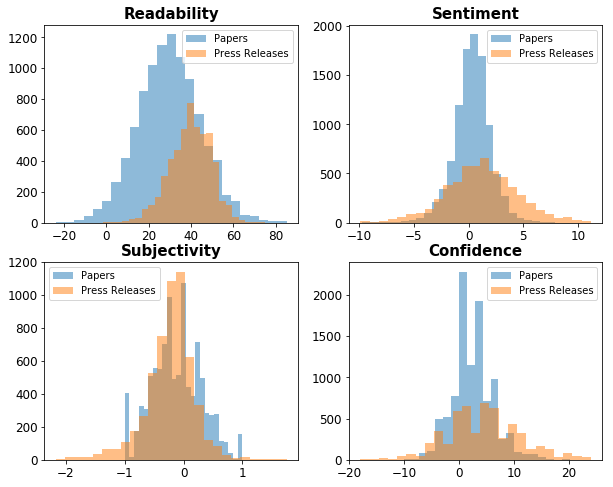

In [28]:
fig, ax = plt.subplots(2, 2, figsize=[10, 8])
#
ax[0, 0].hist(df[df.dat_type == 'Papers']['fks'], bins=25, alpha=0.5, label='Papers');
ax[0, 0].hist(df[df.dat_type == 'PRs']['fks'], bins=25, alpha=0.5, label='Press Releases');
ax[0, 0].set_title("Readability", fontsize=15, fontweight='bold')
ax[0, 0].legend();
ax[0, 0].tick_params(axis='both', which='major', labelsize=12)

ax[0, 1].hist(df[df.dat_type == 'Papers']['vader'], bins=25, alpha=0.5, label='Papers');
ax[0, 1].hist(df[df.dat_type == 'PRs']['vader'], bins=25, alpha=0.5, label='Press Releases');
ax[0, 1].set_title("Sentiment", fontsize=15, fontweight='bold')
ax[0, 1].legend();
ax[0, 1].tick_params(axis='both', which='major', labelsize=12)

ax[1, 0].hist(df[df.dat_type == 'Papers']['subj'], bins=25, alpha=0.5, label='Papers');
ax[1, 0].hist(df[df.dat_type == 'PRs']['subj'], bins=25, alpha=0.5, label='Press Releases');
ax[1, 0].set_title("Subjectivity", fontsize=15, fontweight='bold')
ax[1, 0].legend();
ax[1, 0].tick_params(axis='both', which='major', labelsize=12)

ax[1, 1].hist(df[df.dat_type == 'Papers']['liwc'], bins=25, alpha=0.5, label='Papers');
ax[1, 1].hist(df[df.dat_type == 'PRs']['liwc'], bins=25, alpha=0.5, label='Press Releases');
ax[1, 1].set_title("Confidence", fontsize=15, fontweight='bold')
ax[1, 1].legend();
ax[1, 1].tick_params(axis='both', which='major', labelsize=12)

plt.savefig('test.pdf')

/Users/tom/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


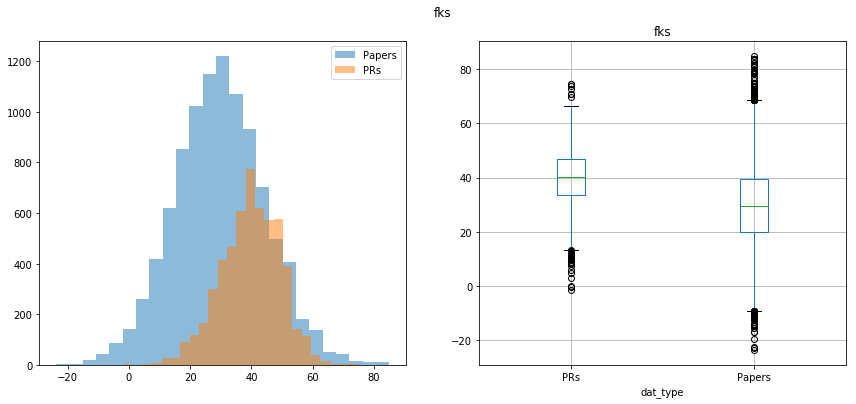

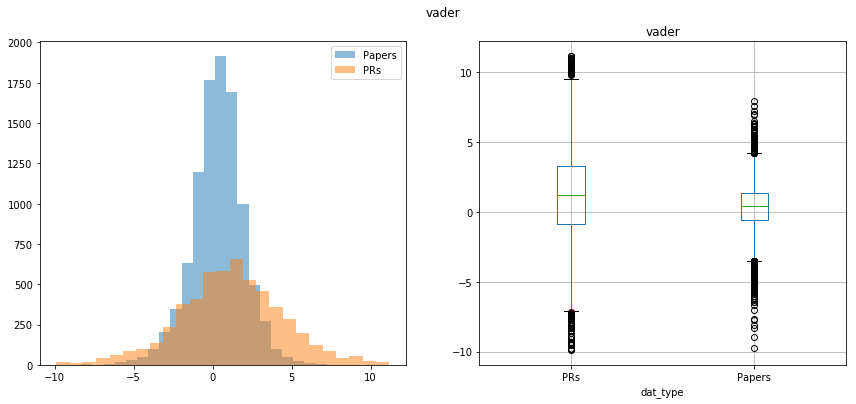

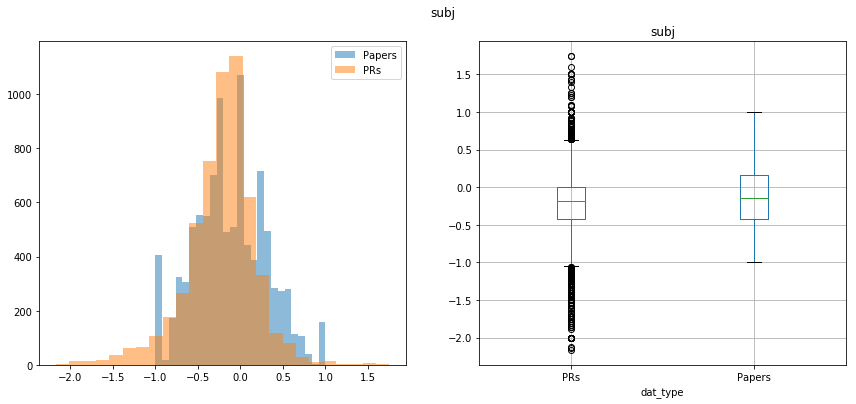

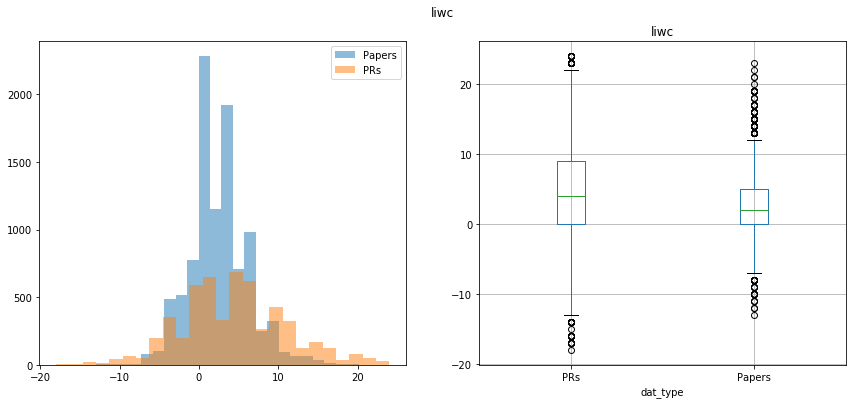

In [29]:
# Plot measures, separated by data type
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    
    
    ax[0].hist(df[df.dat_type == 'Papers'][metric], bins=25, alpha=0.5, label='Papers');
    ax[0].hist(df[df.dat_type == 'PRs'][metric], bins=25, alpha=0.5, label='PRs');
    ax[0].legend()
    
    pd.plotting.boxplot(df, metric, 'dat_type', ax=ax[1])
    
    plt.suptitle(metric)

# STATISTICS!

In [30]:
from statistics import mean, stdev
from math import sqrt

from scipy.stats import ttest_ind
from scipy import stats

In [31]:
# Define Cohen's D
def cohens_d(d1, d2):
    return (mean(d1) - mean(d2)) / (sqrt((stdev(d1) ** 2 + stdev(d2) ** 2) / 2))

In [32]:
#
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    print(metric, '\t', ttest_ind(df[df.dat_type == 'Papers'][metric], df[df.dat_type == 'PRs'][metric]))

fks 	 Ttest_indResult(statistic=-44.923717997809241, pvalue=0.0)
vader 	 Ttest_indResult(statistic=-20.780967399230061, pvalue=1.2787208910488016e-94)
subj 	 Ttest_indResult(statistic=15.119186269176236, pvalue=2.8268375525026069e-51)
liwc 	 Ttest_indResult(statistic=-23.021560828332706, pvalue=2.5018112747980233e-115)


In [33]:
#
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:
for metric in core_metrics:
    print(metric, '\t', cohens_d(df[df.dat_type == 'Papers'][metric], df[df.dat_type == 'PRs'][metric]))

fks 	 -0.798662281669
vader 	 -0.317972410564
subj 	 0.256052870877
liwc 	 -0.357869683149


In [34]:
df.groupby('dat_type')['fkg'].describe()

,count,mean,std,min,25%,50%,75%,max
dat_type,,,,,,,,
PRs,5484.0,13.668691,2.008009,5.6,12.3,13.6,14.9,23.4
Papers,9900.0,14.095071,3.125318,3.3,12.0,14.2,16.2,30.9


In [35]:
# Check direction of effects
df.groupby('dat_type')[core_metrics].describe()

fks                                                            \
           count       mean        std    min    25%    50%     75%    max   
dat_type                                                                     
PRs       5484.0  39.742349   9.659541  -1.55  33.48  40.18  46.910  74.73   
Papers    9900.0  29.765766  14.791018 -23.79  19.90  29.59  39.385  85.08   

           vader                                                          \
           count      mean       std     min      25%      50%       75%   
dat_type                                                                   
PRs       5484.0  1.161377  3.303528 -9.8989 -0.88525  1.20380  3.286650   
Papers    9900.0  0.332289  1.638285 -9.7331 -0.59960  0.39165  1.320325   

                     subj                                                    \
              max   count      mean       std       min       25%       50%   
dat_type                                                                      
PRs       11.1935  5484.0 -0.227776  0.412843 -2.166667 -0.421053 -0.181818   
Papers     7.9335  9900.0 -0.119746  0.430774 -1.000000 -0.428571 -0.142857   

                            liwc                                           \
               75%   max   count      mean       std   min  25%  50%  75%   
dat_type                                                                    
PRs       0.000000  1.75  5484.0  4.386761  6.668496 -18.0  0.0  4.0  9.0   
Papers    0.169118  1.00  9900.0  2.446465  3.784564 -13.0  0.0  2.0  5.0   

                
           max  
dat_type        
PRs       24.0  
Papers    23.0

## ANOVA (?)

Maybe something to do. MESSY EXPLORATIONS.

In [36]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/tom/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [37]:
df.columns

Index(['term', 'smog', 'ar', 'fkg', 'fks', 'lwf', 'vader', 'liu', 'subj',
       'liwc', 'n_words', 'n_sentences', 'has_source_link', 'has_article_link',
       'has_other_link', 'region', 'journal', 'dat_type'],
      dtype='object')

In [38]:
#lm = ols('liwc ~ dat_type + n_words', data=df).fit()
lm = ols('liwc ~ subj + vader + fks + n_words + dat_type', data=df).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [39]:
table

,sum_sq,df,F,PR(>F)
dat_type,1640.364439,1.0,66.692188,3.418534e-16
subj,3661.000874,1.0,148.845069,4.455636e-34
vader,2975.198213,1.0,120.962436,4.953348e-28
fks,366.176397,1.0,14.887609,1.145759e-04
n_words,948.410836,1.0,38.559476,5.447491e-10
Residual,378238.068455,15378.0,NaN,NaN


In [40]:
# compute one-way ANOVA P value   
from scipy import stats  
      
f_val, p_val = stats.f_oneway(df[df.dat_type == 'Papers']['liwc'].values,
                              df[df.dat_type == 'PRs']['liwc'].values)
